In [1]:
import wikipediaapi
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [182]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from io import BytesIO
from transformers import TapasTokenizer, TapasModel, BlipProcessor, BlipForConditionalGeneration, pipeline
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...


True

In [118]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline

## Filter images that are valid and above 200px

In [3]:
def filter_valid_images(image_urls, min_size=200):
    valid_images = []
    for url in image_urls:
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()

            # Check image size
            image = Image.open(response.raw)
            if image.width >= min_size and image.height >= min_size:
                valid_images.append(url)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching image: {url} - {e}")
        except OSError as e:
            print(f"Error opening image: {url} - {e}")

    return valid_images

## Fetch data from a specific wikipedia page

In [4]:
def fetch_wikipedia_page(title, wiki_obj):
    page = wiki_obj.page(title)
    
    if not page.exists():
        return None

    # Text
    content = page.text

    # URL
    url = page.fullurl
    response = requests.get(url, headers={"User-Agent": "EducationalScript/1.0 (nkr4nikhilraj@gmail.com)"})
    
    if response.status_code != 200:
        print(f"Failed to fetch page content for {title}.")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Tables
    tables = [str(table) for table in soup.find_all('table')]

    # Images
    images = ["https:" + img['src'] for img in soup.find_all('img') if 'src' in img.attrs]
    valid_images = filter_valid_images(images, min_size=200)

    return {
        'title': page.title,
        'url': page.fullurl,
        'content': content,
        'tables': tables,
        'images': valid_images,
    }

## Retrieve page data from a wikipedia search

In [5]:
def search_and_fetch_wikipedia(topic, wiki_obj, max_pages=50):
    
    search_url = f"https://en.wikipedia.org/w/index.php?search={topic}&title=Special:Search&limit={max_pages}&profile=advanced&fulltext=1&ns0=1"
    response = requests.get(search_url, headers={"User-Agent": "EducationalScript/1.0 (nkr4nikhilraj@gmail.com)"})
    
    if response.status_code != 200:
        print("Failed to fetch search results.")
        return []
    
    soup = BeautifulSoup(response.text, 'html.parser')
    divs = soup.find_all('div', class_='mw-search-result-heading')

    links = [
        f"https://en.wikipedia.org{a['href']}"
        for div in divs
        for a in div.find_all('a', href=True)
]

    data = []
    for link in links[:max_pages]:
        title = link.split('/')[-1]  # Extract title from URL
        page_data = fetch_wikipedia_page(title, wiki_obj)
        if page_data:
            data.append(page_data)

    return data

In [6]:
data = search_and_fetch_wikipedia(topic="Spiderman", 
                                  wiki_obj=wikipediaapi.Wikipedia(user_agent="I am using it for educational purpose.", language='en'), 
                                  max_pages=5)

Error fetching image: https:/static/images/icons/wikipedia.png - Invalid URL 'https:/static/images/icons/wikipedia.png': No host supplied
Error fetching image: https:/static/images/mobile/copyright/wikipedia-wordmark-en.svg - Invalid URL 'https:/static/images/mobile/copyright/wikipedia-wordmark-en.svg': No host supplied
Error fetching image: https:/static/images/mobile/copyright/wikipedia-tagline-en.svg - Invalid URL 'https:/static/images/mobile/copyright/wikipedia-tagline-en.svg': No host supplied
Error fetching image: https:https://login.wikimedia.org/wiki/Special:CentralAutoLogin/start?type=1x1 - Invalid URL 'https:https://login.wikimedia.org/wiki/Special:CentralAutoLogin/start?type=1x1': No host supplied
Error fetching image: https:/static/images/footer/wikimedia-button.svg - Invalid URL 'https:/static/images/footer/wikimedia-button.svg': No host supplied
Error fetching image: https:/w/resources/assets/poweredby_mediawiki.svg - Invalid URL 'https:/w/resources/assets/poweredby_media

In [7]:
data[0]['title'], data[0]['url'], data[0]['content'][:25], data[0]['images'][0]

('Spider-Man',
 'https://en.wikipedia.org/wiki/Spider-Man',
 'Spider-Man is a superhero',
 'https://upload.wikimedia.org/wikipedia/en/2/21/Web_of_Spider-Man_Vol_1_129-1.png')

In [8]:
df = pd.read_html(data[0]['tables'][0])[0]
df.head()

,Peter Parker Spider-Man,Peter Parker Spider-Man.1
0,Virgin cover of Web of Spider-Man #129.1 (Octo...,Virgin cover of Web of Spider-Man #129.1 (Octo...
1,Publication information,Publication information
2,Publisher,Marvel Comics
3,First appearance,Amazing Fantasy #15 (August 1962)
4,Created by,Stan Lee Steve Ditko


In [ ]:
with open('data/wikipedia.json', 'w') as file:
    json.dump(data, file, indent=4)

##

In [6]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

## Intialize Models

In [7]:
def initialize_models():
    text_model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient open-source text embedding
    tapas_tokenizer = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")
    tapas_model = TapasModel.from_pretrained("google/tapas-base-finetuned-wtq")
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    return text_model, tapas_tokenizer, tapas_model, blip_processor, blip_model

In [8]:
def build_and_save_faiss_index(embeddings, index_path):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    faiss.write_index(index, index_path)
    return index

In [9]:
# Load FAISS index
def load_faiss_index(index_path):
    return faiss.read_index(index_path)

In [10]:
def pad_embedding(embedding, target_dimension):
    embedding_dimension = embedding.shape[1]

    if embedding_dimension < target_dimension:
        # Pad with zeros
        padding_shape = (embedding.shape[0], target_dimension - embedding_dimension)  # Create a tuple
        padding = np.zeros(padding_shape, dtype=embedding.dtype)
        padded_embedding = np.concatenate([embedding, padding], axis=1)
        return padded_embedding
    elif embedding_dimension > target_dimension:
        # Truncate
        return embedding[:, :target_dimension]
    else:
        # Dimensions match, no change needed
        return embedding

In [11]:
# Retrieve top-k results
def retrieve_top_k(query_embedding, index, k=5):
    # Check if query embedding dimension matches index dimension
    query_embedding_dimension = query_embedding.shape[1]  # Get column dimension
    index_dimension = index.d  # Assumed correct attribute name

    if query_embedding_dimension != index_dimension:
        # Adjust the embedding to match the index dimension
        print(f"Query embedding dimension ({query_embedding_dimension}) does not match index dimension ({index_dimension}). Hence, embeddings are adjusted.")

        query_embedding = pad_embedding(query_embedding, index_dimension)

    # Now perform the search
    distances, indices = index.search(query_embedding, k)
    return distances, indices

In [12]:
data = load_data("data/wikipedia.json")

In [13]:
text_model, tapas_tokenizer, tapas_model, blip_processor, blip_model = initialize_models()

## Text Data

In [14]:
def chunk_text_by_sentences(text, chunk_size=5, overlap_size=2):
    sentences = sent_tokenize(text)
    chunks = []

    for i in range(0, len(sentences), chunk_size - overlap_size):
        chunk = sentences[i:i + chunk_size]
        chunks.append(" ".join(chunk))
    
    return chunks

In [15]:
def embed_text(data, text_model, chunk_size=5, overlap_size=2):
    all_chunks = []
    for entry in data:
        chunks = chunk_text_by_sentences(entry['content'], chunk_size, overlap_size)
        all_chunks.extend(chunks)

    # Generate aaaembeddings for all chunks
    text_embeddings = text_model.encode(all_chunks, convert_to_tensor=False)
    return np.array(text_embeddings), all_chunks

In [16]:
text_embeddings, text_metadata = embed_text(data, text_model, chunk_size=5, overlap_size=0)

In [17]:
text_embeddings.shape, len(text_metadata)

((180, 384), 180)

In [18]:
text_embeddings[0]

array([-5.47028705e-02, -4.01979461e-02, -5.70011921e-02, -3.73883964e-03,
       -1.83920655e-03, -3.82639654e-02,  2.67207045e-02, -6.17552875e-03,
       -6.65126517e-02,  3.81660499e-02, -5.00768572e-02,  5.50043881e-02,
       -3.92910168e-02,  4.41360846e-02,  6.87296316e-02,  7.48750865e-02,
        5.43188537e-03,  1.53266899e-02,  8.30153562e-03, -3.89266293e-03,
        7.06539974e-02, -3.42544839e-02,  1.40959444e-02, -1.36268288e-01,
       -2.08618660e-02,  3.95920351e-02,  5.83843179e-02,  8.03527143e-03,
        2.83188690e-02,  1.73087250e-02, -7.64736719e-03,  2.64412854e-02,
       -4.63708565e-02, -3.47807147e-02, -6.36748224e-02, -5.54643013e-02,
       -1.51460012e-02,  6.81297630e-02,  2.21516844e-03, -2.55007930e-02,
       -5.21445796e-02,  8.57020393e-02, -6.13551475e-02, -2.64820387e-03,
        1.31948283e-02, -3.49755362e-02, -6.16967231e-02,  1.82890035e-02,
        9.31313634e-03, -2.13143490e-02,  3.75105627e-03,  6.57428056e-02,
        2.36040950e-02,  

In [19]:
text_metadata[0]

'Spider-Man is a superhero in American comic books published by Marvel Comics. Created by writer-editor Stan Lee and artist Steve Ditko, he first appeared in the anthology comic book Amazing Fantasy #15 (August 1962) in the Silver Age of Comic Books. He has been featured in comic books, television shows, films, video games, novels, and plays. Spider-Man has the secret identity of Peter Benjamin Parker. Initially, Peter was depicted as a teenage high-school student and an orphan raised by his Aunt May and Uncle Ben in New York City after his parents, Richard and Mary Parker, died in a plane crash.'

In [21]:
text_index = build_and_save_faiss_index(text_embeddings, "vector_store/text_index.faiss")

## Tabular Data

In [20]:
def embed_tables_with_tapas(data, tapas_tokenizer, tapas_model):
    table_embeddings = []
    table_metadata = []

    for entry in data:
        for table_html in entry.get('tables', []):
            try:
                df = pd.read_html(str(table_html))[0]
                # Check if rows are empty before proceeding
                if len(df) <= 3:
                    continue  # Skip to the next table

                inputs = tapas_tokenizer(table=df, queries=["What does this table mean?"], padding="max_length", truncation=True, return_tensors="pt")

                # Generate embeddings
                outputs = tapas_model(**inputs)
                embedding = outputs.pooler_output.detach().numpy()

                table_embeddings.append(embedding)
                table_metadata.append(table_html)
            except Exception as e:
                print(f"Error processing table: {e}")
    return np.vstack(table_embeddings), table_metadata

In [21]:
table_embeddings, table_metadata = embed_tables_with_tapas(data, tapas_tokenizer, tapas_model)

Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: expected string or bytes-like object
Error processing table: 

In [22]:
table_embeddings.shape, len(table_metadata)

((63, 768), 63)

In [23]:
table_embeddings[0]

array([-0.9573766 ,  0.9929301 , -0.99223936,  0.9664185 , -0.522578  ,
       -0.85771036, -0.38700542,  0.8430534 ,  0.8987512 , -0.87391233,
        0.985724  , -0.9960578 ,  0.95052683,  0.99117035, -0.8545571 ,
       -0.21331124,  0.9891235 ,  0.9251129 , -0.62765455, -0.97634465,
       -0.25308293,  0.8441898 ,  0.871315  , -0.15930118, -0.7295173 ,
       -0.98527783,  0.8290879 ,  0.8710989 ,  0.9879803 ,  0.19387035,
       -0.97425115,  0.95764256, -0.99557495,  0.95696014,  0.63984317,
       -0.9944125 ,  0.99292994, -0.99812186, -0.91791457, -0.41166487,
        0.6926246 ,  0.9743937 ,  0.9992176 , -0.8292757 ,  0.20020077,
        0.7807222 , -0.9998078 , -0.7904239 ,  0.7482508 ,  0.56776756,
        0.99116105, -0.34333423, -0.9816723 ,  0.99231637, -0.61928904,
       -0.8992802 , -0.7676618 , -0.98333085, -0.9897054 , -0.8120302 ,
       -0.92341715,  0.90085256,  0.9928164 ,  0.94443   , -0.9832385 ,
        0.9914827 ,  0.5807884 , -0.8259422 , -0.9687098 , -0.80

In [24]:
pd.read_html(table_metadata[0])[0]

,Peter Parker Spider-Man,Peter Parker Spider-Man.1
0,Virgin cover of Web of Spider-Man #129.1 (Octo...,Virgin cover of Web of Spider-Man #129.1 (Octo...
1,Publication information,Publication information
2,Publisher,Marvel Comics
3,First appearance,Amazing Fantasy #15 (August 1962)
4,Created by,Stan Lee Steve Ditko
5,In-story information,In-story information
6,Full name,Peter Benjamin Parker
7,Species,Human mutate[a]
8,Place of origin,"Queens, New York City"
9,Team affiliations,Avengers Fantastic Four X-Men Secret Defenders...


In [100]:
table_index = build_and_save_faiss_index(table_embeddings, "vector_store/table_index.faiss")

In [28]:
test_df = pd.read_html(table_metadata[1])[0]
test_df.head()

,Supervillain name / Supervillain team name,Alter ego / group member,First appearance,Creator
0,Chameleon,Dmitri Nikolayevich,The Amazing Spider-Man #1 (March 1963)[118][119],Stan Lee[118][119] Steve Ditko[118][119]
1,Vulture,Adrian Toomes,The Amazing Spider-Man #2 (May 1963)[120][121],Stan Lee[120][122] Steve Ditko[120]
2,Doctor Octopus,Otto Octavius1,The Amazing Spider-Man #3 (July 1963)[119],Stan Lee[123][124] Steve Ditko[15][124]
3,Sandman,William Baker / Flint Marko,The Amazing Spider-Man #4 (Sept. 1963)[125][126],Stan Lee[125][126] Steve Ditko[125][126]
4,Lizard,Curt Connors,The Amazing Spider-Man #6 (Nov. 1963)[127][128...,Stan Lee[127][128][129] Steve Ditko[127][128][...


In [31]:
tapas_input = tapas_tokenizer(table=test_df, queries=["What does this table mean?"], padding="max_length", truncation=True, return_tensors="pt")

In [32]:
outputs = tapas_model(**tapas_input)
embedding = outputs.pooler_output.detach().numpy()

In [34]:
embedding

array([[ 0.5141663 ,  0.46733826, -0.9998728 ,  0.56873864,  0.80466515,
        -0.30854508,  0.7650394 ,  0.61052245, -0.97028327, -0.928885  ,
         0.6039998 ,  0.8811063 , -0.58744425,  0.90840834, -0.7690476 ,
         0.17269588,  0.93527555,  0.4395131 , -0.22122192, -0.7995852 ,
        -0.80476433,  0.9999854 ,  0.37564763, -0.17149174,  0.1925329 ,
         0.92751104, -0.5182449 ,  0.5830237 , -0.76467466, -0.6206615 ,
        -0.26636976,  0.82374465,  0.56714314,  0.96191216, -0.97102493,
        -0.41259181,  0.38791865, -0.25235188,  0.26147872,  0.459242  ,
         0.9633597 ,  0.7839265 ,  0.94507706,  0.8567807 ,  0.9417181 ,
        -0.2459628 , -0.9991218 ,  0.45604095,  0.95964676,  0.9979029 ,
         0.9994572 ,  0.88781   , -0.9605453 ,  0.08389586, -0.43574437,
        -0.70008534, -0.8133243 , -0.9771958 ,  0.4846621 ,  0.12321641,
        -0.41046146,  0.423046  , -0.9083782 ,  0.9878887 ,  0.94607675,
         0.9827876 ,  0.893419  , -0.8163206 , -0.7

In [93]:
def flatten_df_rows(df):
    flattened_rows = "\n".join([", ".join([f"{col}: {row[col]}" for col in df.columns]) for _, row in df.iterrows()])

    return flattened_rows

In [94]:
flatten_df = flatten_df_rows(test_df)

In [95]:
flatten_df

'Supervillain name / Supervillain team name: Chameleon, Alter ego / group member: Dmitri Nikolayevich, First appearance: The Amazing Spider-Man #1 (March 1963)[118][119], Creator: Stan Lee[118][119] Steve Ditko[118][119]\nSupervillain name / Supervillain team name: Vulture, Alter ego / group member: Adrian Toomes, First appearance: The Amazing Spider-Man #2 (May 1963)[120][121], Creator: Stan Lee[120][122] Steve Ditko[120]\nSupervillain name / Supervillain team name: Doctor Octopus, Alter ego / group member: Otto Octavius1, First appearance: The Amazing Spider-Man #3 (July 1963)[119], Creator: Stan Lee[123][124] Steve Ditko[15][124]\nSupervillain name / Supervillain team name: Sandman, Alter ego / group member: William Baker / Flint Marko, First appearance: The Amazing Spider-Man #4 (Sept. 1963)[125][126], Creator: Stan Lee[125][126] Steve Ditko[125][126]\nSupervillain name / Supervillain team name: Lizard, Alter ego / group member: Curt Connors, First appearance: The Amazing Spider-Ma

In [96]:
len(flatten_df)

4050

In [97]:
def embed_tables(data, text_model):
    table_embeddings = []
    table_metadata = []

    for entry in data:
        for table_html in entry.get('tables', []):
            try:
                df = pd.read_html(str(table_html))[0]
                # Check if rows are empty before proceeding
                if len(df) <= 3:
                    continue  # Skip to the next table

                flattened_df = flatten_df_rows(df)

                # Generate embeddings
                embedding = text_model.encode(flattened_df)

                table_embeddings.append(embedding)
                table_metadata.append(table_html)
            except Exception as e:
                print(f"Error processing table: {e}")
    return np.vstack(table_embeddings), table_metadata

In [98]:
table_embeddings, table_metadata = embed_tables(data, text_model)

In [99]:
table_embeddings.shape, len(table_metadata)

((87, 384), 87)

## Image Data

In [43]:
def embed_images_with_blip(data, blip_processor, blip_model, text_model):
    image_embeddings = []
    image_metadata = []

    for entry in data:
        for url in entry.get('images', []):
            try:
                # Download image
                response = requests.get(url, stream=True)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content)).convert("RGB")

                # Generate caption using BLIP
                inputs = blip_processor(images=img, return_tensors="pt")
                outputs = blip_model.generate(**inputs)
                caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                
                print(f"For Image: {url}, the generated caption is {caption}")

                # Generate text embedding from caption
                embedding = text_model.encode([caption])
                image_embeddings.append(embedding)
                image_metadata.append(url)

            except Exception as e:
                print(f"Error processing image {url}: {e}")

    return np.vstack(image_embeddings), image_metadata

In [44]:
image_embeddings, image_metadata = embed_images_with_blip(data, blip_processor, blip_model, text_model)

For Image: https://upload.wikimedia.org/wikipedia/en/2/21/Web_of_Spider-Man_Vol_1_129-1.png, the generated caption is spiderman is jumping over a street sign
For Image: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Spider_Strikes_v1n1_i05_Wentworth.png/220px-Spider_Strikes_v1n1_i05_Wentworth.png, the generated caption is a black and white drawing of a man with a broken face
For Image: https://upload.wikimedia.org/wikipedia/en/thumb/3/35/Amazing_Fantasy_15.jpg/228px-Amazing_Fantasy_15.jpg, the generated caption is amazing spider - man vol 1
For Image: https://upload.wikimedia.org/wikipedia/en/thumb/b/bd/Issue252.jpg/220px-Issue252.jpg, the generated caption is amazing spiderman 1963 1 - a by marvel
For Image: https://upload.wikimedia.org/wikipedia/en/2/21/Web_of_Spider-Man_Vol_1_129-1.png, the generated caption is spiderman is jumping over a street sign
For Image: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Spider_Strikes_v1n1_i05_Wentworth.png/220px-Spider_Str

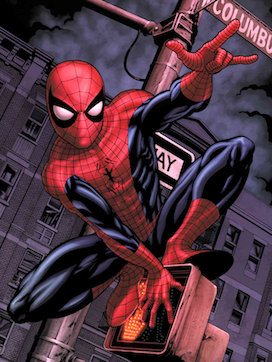

In [46]:
response_img = requests.get("https://upload.wikimedia.org/wikipedia/en/2/21/Web_of_Spider-Man_Vol_1_129-1.png", stream=True)
img = Image.open(BytesIO(response_img.content)).convert("RGB")
display(img)

In [47]:
input_img = blip_processor(images=img, return_tensors="pt")
outputs = blip_model.generate(**input_img)
caption = blip_processor.decode(outputs[0], skip_special_tokens=True)

In [49]:
print(f"Genrated caption : {caption}")

Genrated caption : spiderman is jumping over a street sign


In [50]:
image_index = build_and_save_faiss_index(image_embeddings, "vector_store/image_index.faiss")

## Retrieval

In [84]:
user_query = "Who is Spiderman?"

In [101]:
text_index = load_faiss_index("vector_store/text_index.faiss")
table_index = load_faiss_index("vector_store/table_index.faiss")
image_index = load_faiss_index("vector_store/image_index.faiss")

In [86]:
user_query_embedding = text_model.encode([user_query], convert_to_tensor=False)

In [87]:
user_query_embedding.shape

(1, 384)

In [88]:
text_distances, text_indices = retrieve_top_k(user_query_embedding, text_index, k=1)
text_results = [text_metadata[i] for i in text_indices[0]]

In [89]:
text_results

['Spider-Man is a superhero in American comic books published by Marvel Comics. Created by writer-editor Stan Lee and artist Steve Ditko, he first appeared in the anthology comic book Amazing Fantasy #15 (August 1962) in the Silver Age of Comic Books. He has been featured in comic books, television shows, films, video games, novels, and plays. Spider-Man has the secret identity of Peter Benjamin Parker. Initially, Peter was depicted as a teenage high-school student and an orphan raised by his Aunt May and Uncle Ben in New York City after his parents, Richard and Mary Parker, died in a plane crash.']

In [90]:
text_distances

array([[0.6010426]], dtype=float32)

In [102]:
table_distances, table_indices = retrieve_top_k(user_query_embedding, table_index, k=5)
table_results = [table_metadata[i] for i in table_indices[0]]

In [103]:
table_results

['<table class="nowraplinks hlist mw-collapsible expanded navbox-inner" style="border-spacing:0;background:transparent;color:inherit"><tbody><tr><th class="navbox-title" colspan="2" scope="col"><link href="mw-data:TemplateStyles:r1129693374" rel="mw-deduplicated-inline-style"/><style data-mw-deduplicate="TemplateStyles:r1239400231">.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:"[ "}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:" ]"}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:no

In [104]:
table_distances

array([[0.85444784, 0.85444784, 0.88072467, 0.88072467, 0.8868701 ]],
      dtype=float32)

In [106]:
table_df = pd.read_html(table_results[0])[0]
table_df

,vteSpider-Man,vteSpider-Man.1
0,Stan Lee Steve Ditko,Stan Lee Steve Ditko
1,Characters,Peter Parker Ben Reilly Miguel O'Hara Miles Mo...
2,Features and locations,Daily Bugle Oscorp Life Foundation Parker Indu...
3,Comic books,The Amazing Spider-Man Storylines Collected Ed...
4,Other media,In film In television In video games Marvel's ...
5,Toys,The Amazing Spider-Man (pinball) Spider-Man (p...
6,See also,"Bibliography of works on Spider-Man ""With grea..."
7,Category,Category


In [90]:
image_distances, image_indices = retrieve_top_k(user_query_embedding, image_index, k=1)
image_results = [image_metadata[i] for i in image_indices[0]]

In [91]:
image_distances

array([[0.79009086]], dtype=float32)

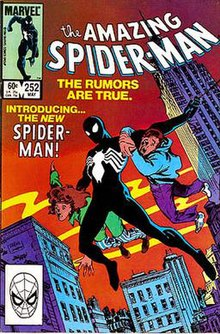

In [93]:
response_img = requests.get(image_results[0], stream=True)
img = Image.open(BytesIO(response_img.content)).convert("RGB")
display(img)

## LLM

In [162]:
model_name = "facebook/opt-1.3b"  # Replace with your specific model if available
tokenizer = AutoTokenizer.from_pretrained(model_name)
llm_pipeline = pipeline(
    "text-generation", 
    model=AutoModelForCausalLM.from_pretrained(model_name), 
    tokenizer=tokenizer,
    max_new_tokens=100,
    temperature=0.1,
    top_k=50,
    repetition_penalty=1.2
)

In [163]:
llm = HuggingFacePipeline(pipeline=llm_pipeline)

In [164]:
retrieved_context = text_metadata[0]

In [165]:
prompt_template = PromptTemplate(
    template="Given the context: {context}, answer the question: {question}. ",
    input_variables=["context", "question"]
)

In [166]:
formatted_prompt = prompt_template.format(context=retrieved_context, question=user_query)
formatted_prompt

'Given the context: Spider-Man is a superhero in American comic books published by Marvel Comics. Created by writer-editor Stan Lee and artist Steve Ditko, he first appeared in the anthology comic book Amazing Fantasy #15 (August 1962) in the Silver Age of Comic Books. He has been featured in comic books, television shows, films, video games, novels, and plays. Spider-Man has the secret identity of Peter Benjamin Parker. Initially, Peter was depicted as a teenage high-school student and an orphan raised by his Aunt May and Uncle Ben in New York City after his parents, Richard and Mary Parker, died in a plane crash., answer the question: Who is Spiderman?. '

In [167]:
result = llm(formatted_prompt)

In [168]:
print(result)

Given the context: Spider-Man is a superhero in American comic books published by Marvel Comics. Created by writer-editor Stan Lee and artist Steve Ditko, he first appeared in the anthology comic book Amazing Fantasy #15 (August 1962) in the Silver Age of Comic Books. He has been featured in comic books, television shows, films, video games, novels, and plays. Spider-Man has the secret identity of Peter Benjamin Parker. Initially, Peter was depicted as a teenage high-school student and an orphan raised by his Aunt May and Uncle Ben in New York City after his parents, Richard and Mary Parker, died in a plane crash., answer the question: Who is Spiderman?.  Answer: Spiderman is a fictional character created by Stan Lee and Steve Ditko for use in their series of comics published by Marvel Comics from 1963 to 1971. The character's name comes from the Greek word "spider", which means "web".

Spider-Man debuted on August 15, 1963, in Amazing Fantasy #15, written by Lee and drawn by Ditko. In

## Page Ranking

In [169]:
with open('data/wikipedia.json', 'r') as f:
    wikipedia_data = json.load(f)

In [170]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [173]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

In [195]:
def create_faiss_page_index(wikipedia_data, model):
    embeddings = []
    urls = []
    title = []
    for page in wikipedia_data:
        preprocessed_content = preprocess_text(page['content'])
        embedding = model.encode(preprocessed_content)
        embeddings.append(embedding)
        urls.append(page['url'])
        title.append(page['title'])

    embeddings = np.array(embeddings)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index, urls, title

In [196]:
index, urls, title = create_faiss_page_index(wikipedia_data, text_model)

In [197]:
urls

['https://en.wikipedia.org/wiki/Spider-Man',
 'https://en.wikipedia.org/wiki/Spider-Man',
 'https://en.wikipedia.org/wiki/Alain_Robert',
 'https://en.wikipedia.org/wiki/Italian_Spiderman']

In [198]:
query_embedding = text_model.encode(user_query)

In [199]:
distances, indices = index.search(query_embedding.reshape(1, -1), k=5)

In [200]:
for i in range(5):
    print(f"{distances[0][i]:.2f} - {urls[indices[0][i]]} - {title[indices[0][i]]}")

0.75 - https://en.wikipedia.org/wiki/Spider-Man - Spider-Man
0.75 - https://en.wikipedia.org/wiki/Spider-Man - Spider-Man
0.96 - https://en.wikipedia.org/wiki/Italian_Spiderman - Italian Spiderman
1.35 - https://en.wikipedia.org/wiki/Alain_Robert - Alain Robert
340282346638528859811704183484516925440.00 - https://en.wikipedia.org/wiki/Italian_Spiderman - Italian Spiderman
